In [1]:
import pandas as pd    #Processing Data from Spreadsheet
import numpy as np
from scipy.integrate import odeint #Ordinary differential equation solver
import matplotlib.pyplot as plt    #For graph plotting
import pyswarms as ps

In [35]:
def deriv(state, t, N, beta, gamma):
    S, I, R = state
    # Change in S population over time
    dSdt = -beta * S * I / N
    # Change in I population over time
    dIdt = beta * S * I / N - gamma * I
    # Change in R population over time
    dRdt = gamma * I
    return dSdt, dIdt, dRdt

23876.35498655222


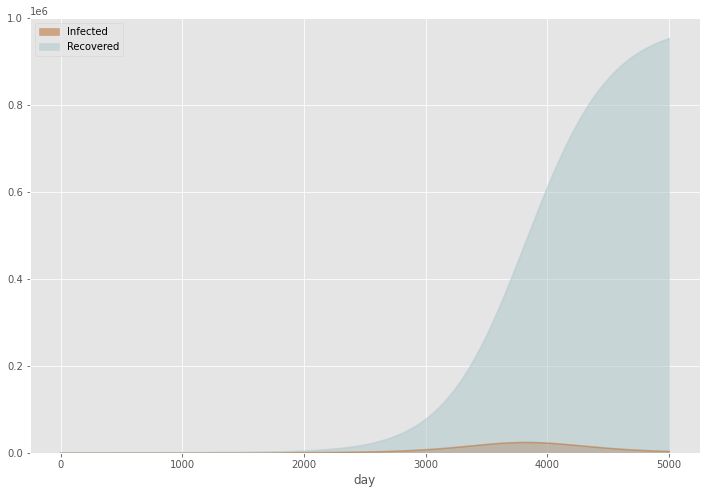

In [43]:
N = 5600000
Removed = 0
Infected = 1
Susceptible = N - Infected - Removed
Max_Day=5000

def Solve_SIR(beta, gamma):
    
    # A list of days, 0~Iterations
    days = range(0, Max_Day+1)

    # Use differential equations magic with our population
    ret = odeint(deriv,
                 [Susceptible, Infected, Removed],
                 days,
                 args=(N, beta, gamma))
    S, I, R = ret.T     # all three variables S, I, R store a list of the
                        #number of people in each case from day 0 to 159

    return S, I, R

S, I, R = Solve_SIR(0.030117*1.1,0.030117)
print(max(I))

days=[]
for i in range(0,Max_Day+1):
    days.append(i)
    
df = pd.DataFrame({
    'day': days,
    'Susceptible': S,
    'Infected': I,
    'Recovered': R
})

plt.style.use('ggplot')
df.plot(x='day',
        y=['Infected', 'Recovered'],
        color=['#bb6424', '#aac6ca'],
        kind='area',
        figsize=(12,8),
        stacked=False)

## SIRQ+V model

In [43]:
def deriv2(state, t, N, alpha, beta, gamma, delta, sigma):
    S, I, Q, R, V = state
    # Change in S population over time
    dSdt = -beta*S*I/N - alpha*S + sigma*beta*V*I/N
    # Change in I population over time
    dIdt = beta*S*I/N - delta*I
    # Change in Q population over time
    dQdt = delta*I - gamma*Q
    # Change in R population over time
    dRdt = gamma*Q
    # Change in V popuation over time
    dVdt = alpha*S - sigma*beta*V*I/N
    
    return dSdt, dIdt, dQdt, dRdt, dVdt

In [65]:
N = 5600000
Removed = 0
Infected = 1
Susceptible = N - Infected - Removed
Quarantined = 0
Vaccinated = 0

def Solve_SIQRV(alpha, beta, gamma, delta, sigma):
    
    # A list of days, 0~Iterations
    days = range(0, 365)

    # Use differential equations magic with our population
    ret = odeint(deriv2,
                 [Susceptible, Infected, Quarantined, Removed, Vaccinated],
                 days,
                 args=(N, alpha, beta, gamma, delta, sigma))
    S, I, Q, R, V = ret.T     # all three variables S, I, R store a list of the
                        #number of people in each case from day 0 to 159

    return S, I, Q, R, V

S, I, Q, R, V = Solve_SIQRV(0.001, 0.1246, 0.030117, 0.030117, 0.001)
print(max(I))


1680428.6367690756


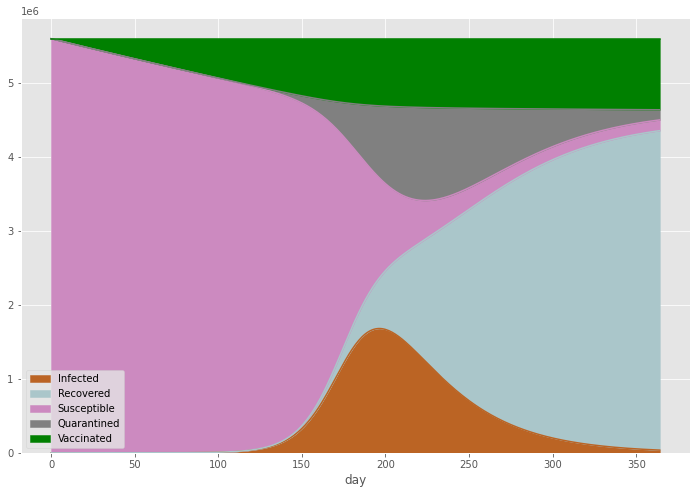

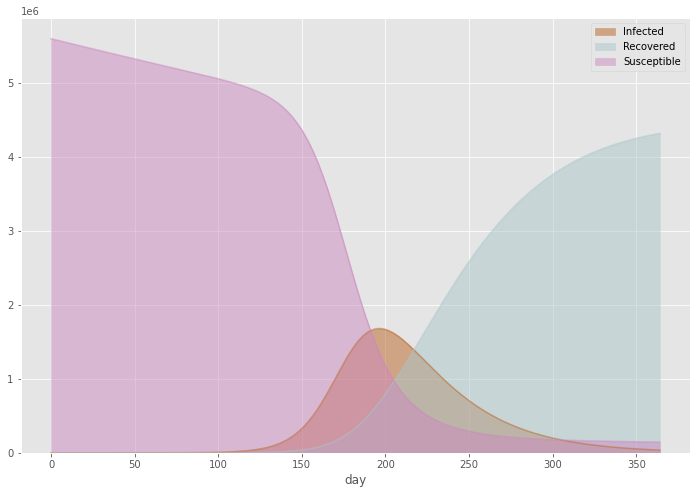

In [67]:
#Plotting graph
days=[]
for i in range(0,365):
    days.append(i)
    
df = pd.DataFrame({
    'day': days,
    'Susceptible': S,
    'Infected': I,
    'Quarantined': Q,
    'Recovered': R,
    'Vaccinated': V
})

plt.style.use('ggplot')
df.plot(x='day',
        y=['Infected', 'Recovered', 'Susceptible', 'Quarantined', 'Vaccinated'],
        color=['#bb6424', '#aac6ca', '#cc8ac0', 'grey', 'green'],
        kind='area',
        figsize=(12,8),
        stacked=True)

plt.style.use('ggplot')
df.plot(x='day',
        y=['Infected', 'Recovered', 'Susceptible'],
        color=['#bb6424', '#aac6ca', '#cc8ac0'],
        kind='area',
        figsize=(12,8),
        stacked=False)

## SIR+V model

In [2]:
#Alpha: vaccination rate (fraction of the population)
#beta: transmission rate (probability of infecting a neighbour)
#gamma: recovery rate (probability of an infected to recover)
#sigma: vaccine inefficiency (for Pfizer, vaccine efficacy is 91%)
def deriv3(state, t, N, alpha, beta, gamma, sigma):
    S, I, R, V = state
    # Change in S population over time
    dSdt = -beta*S*I/N - alpha*S + sigma*beta*V*I/N
    # Change in I population over time
    dIdt = beta*S*I/N - gamma*I
    # Change in R population over time
    dRdt = gamma*I
    # Change in V popuation over time
    dVdt = alpha*S - sigma*beta*V*I/N
    
    return dSdt, dIdt, dRdt, dVdt

In [4]:
N = 5600000
Removed = 0
Infected = 1
Susceptible = N - Infected - Removed
Vaccinated = 0
Max_Day=730

def Solve_SIRV(alpha, beta, gamma, sigma):
    
    # A list of days, 0~Iterations
    days = range(0, Max_Day+1)

    # Use differential equations magic with our population
    ret = odeint(deriv3,
                 [Susceptible, Infected, Removed, Vaccinated],
                 days,
                 args=(N, alpha, beta, gamma, sigma))
    S, I, R, V = ret.T     # all three variables S, I, R store a list of the
                        #number of people in each case from day 0 to 159

    return S, I, R, V

S, I, R, V = Solve_SIRV(0.002, 0.1246, 0.030117, 0.09)
print("Max I:",max(I))
print("Last I:",I[Max_Day])
print("Max R:",max(R))

Max I: 1130475.4512746993
Last I: 7.696026292028072
Max R: 3706349.9574190816


In [47]:
#Calculating & Exporting vaccination rate required to keep virus under control
def Vac_Rate(prev, R0):
    for i in range(prev,1000000):
        alpha = i/1000000
        S, I, R, V = Solve_SIRV(alpha, 0.030117*R0, 0.030117, 0.09)
        if max(R)+I[Max_Day]<=N*0.01: #1% of total population
            #print(alpha)
            #print("Vaccination Rate:",N*alpha,"people per day.")
            return alpha
    return -1

def main():
    ExcelFrame = {"R0":[], "Vaccination rate":[], "Vaccination per day": []}
    
    prev_alpha=1
    for R0 in range(11,51):
        alpha = Vac_Rate(prev_alpha, R0/10)
        prev_alpha = int(alpha*1000000)
        print(R0/10, alpha, N*alpha)
        ExcelFrame['R0'].append(R0/10)
        ExcelFrame['Vaccination rate'].append(alpha)
        ExcelFrame['Vaccination per day'].append(N*alpha)
        
    writer = pd.ExcelWriter('Vaccination Rate.xlsx', engine='xlsxwriter')
    df = pd.DataFrame(ExcelFrame)
    df.to_excel(writer, sheet_name='Vac_Rate', index=False)
    writer.save()

main()

1.1 2e-05 112.00000000000001
1.2 7.5e-05 419.99999999999994
1.3 0.000152 851.2
1.4 0.000249 1394.3999999999999
1.5 0.000362 2027.2
1.6 0.000489 2738.3999999999996
1.7 0.000627 3511.2
1.8 0.000776 4345.6
1.9 0.000934 5230.400000000001
2.0 0.001099 6154.4
2.1 0.001272 7123.2
2.2 0.001451 8125.6
2.3 0.001635 9156.0
2.4 0.001825 10220.0
2.5 0.00202 11312.0
2.6 0.002218 12420.8
2.7 0.002421 13557.6
2.8 0.002627 14711.2
2.9 0.002836 15881.6
3.0 0.003048 17068.8
3.1 0.003264 18278.4
3.2 0.003481 19493.600000000002
3.3 0.003701 20725.6
3.4 0.003924 21974.4
3.5 0.004148 23228.8
3.6 0.004375 24500.000000000004
3.7 0.004603 25776.800000000003
3.8 0.004833 27064.8
3.9 0.005065 28364.0
4.0 0.005298 29668.8
4.1 0.005533 30984.8
4.2 0.005769 32306.399999999998
4.3 0.006006 33633.6
4.4 0.006245 34972.0
4.5 0.006484 36310.4
4.6 0.006725 37660.0
4.7 0.006967 39015.2
4.8 0.00721 40376.0
4.9 0.007454 41742.4
5.0 0.007699 43114.4


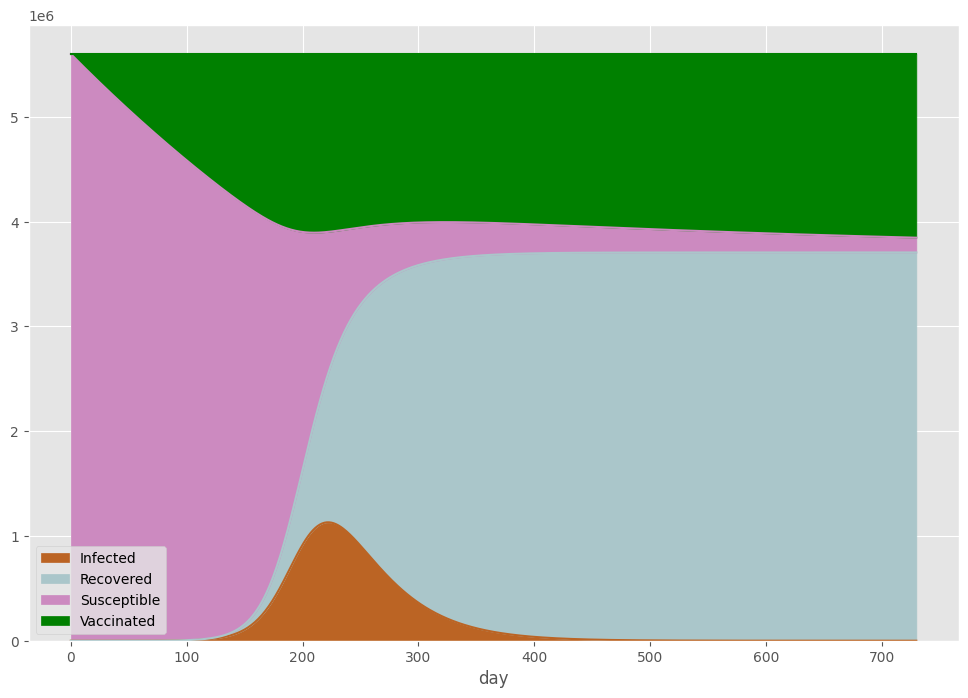

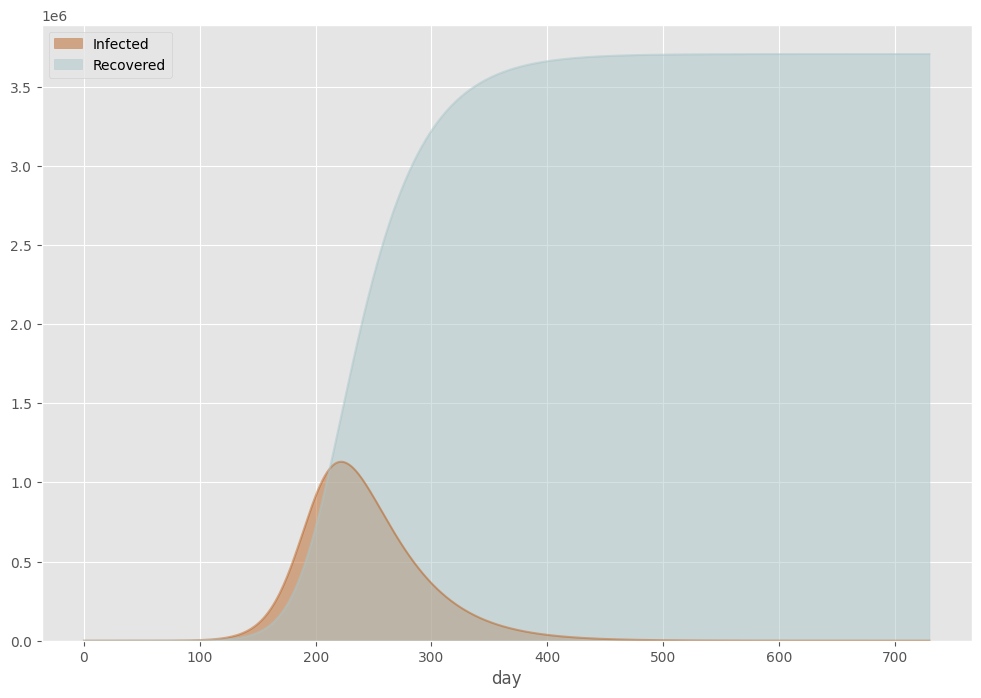

In [6]:
#Plotting graph
days=[]
for i in range(0,Max_Day+1):
    days.append(i)
    
df = pd.DataFrame({
    'day': days,
    'Susceptible': S,
    'Infected': I,
    'Recovered': R,
    'Vaccinated': V
})

plt.style.use('ggplot')
df.plot(x='day',
        y=['Infected', 'Recovered', 'Susceptible', 'Vaccinated'],
        color=['#bb6424', '#aac6ca', '#cc8ac0', 'green'],
        kind='area',
        figsize=(12,8),
        stacked=True)

plt.style.use('ggplot')
df.plot(x='day',
        y=['Infected', 'Recovered'],
        color=['#bb6424', '#aac6ca'],
        kind='area',
        figsize=(12,8),
        stacked=False)

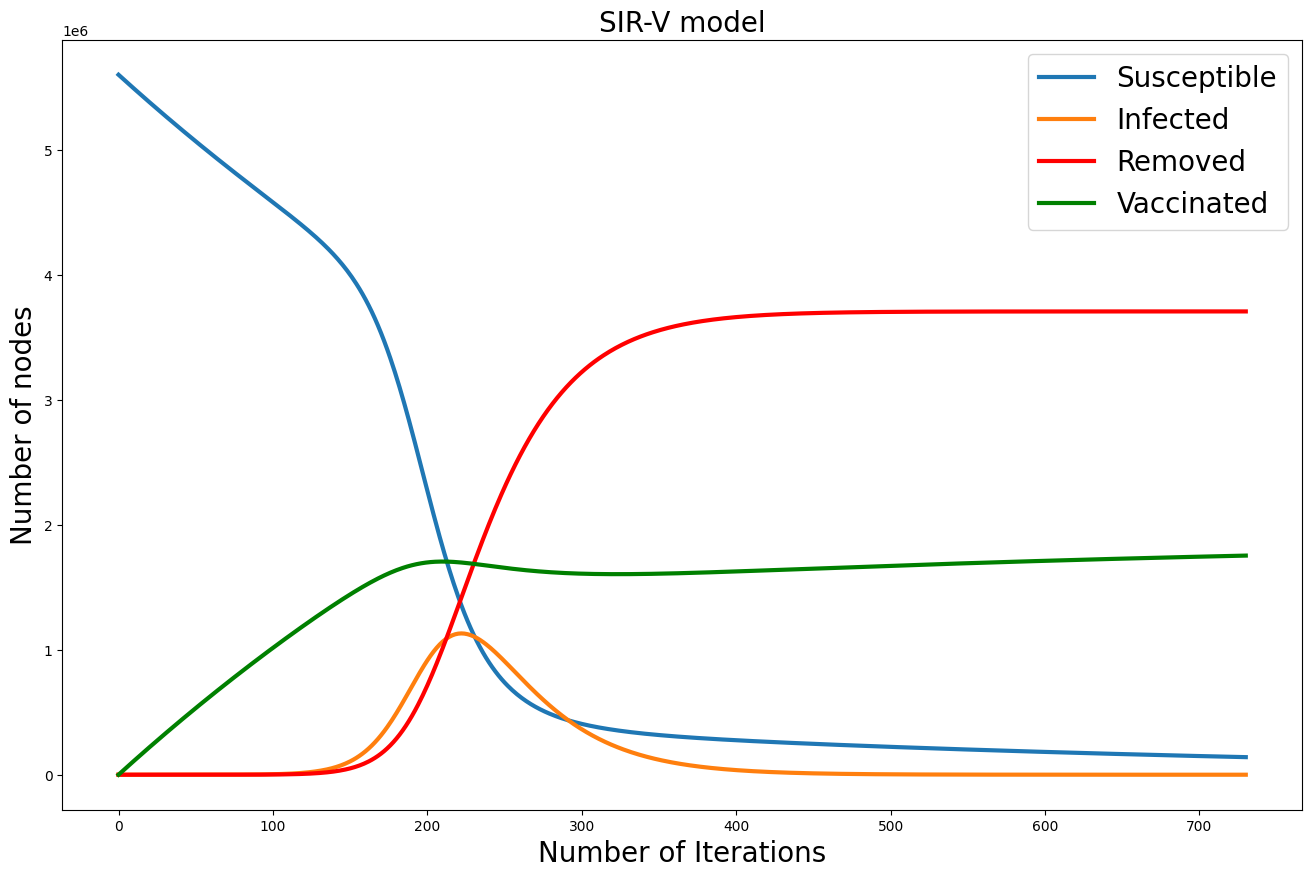

In [12]:
plt.style.use('default')
plt.figure(figsize=(16,10))
plt.plot(days, S, label = "Susceptible", linewidth=3)
plt.plot(days, I, label = "Infected", linewidth=3)
plt.plot(days, R, label = "Removed",color="red", linewidth=3)
plt.plot(days, V, label = "Vaccinated", color="green", linewidth=3)
plt.xlabel('Number of Iterations',fontsize=20)
plt.ylabel('Number of nodes',fontsize=20)
#plt.title('SIR-V model',fontsize=20)
plt.legend(fontsize=20)
plt.savefig('books_read.png')
plt.show()